# Import de librairies

In [20]:
%matplotlib widget
import pandas as pd
import numpy as np
import tensorflow  as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import np_utils

In [2]:
x_train=pd.read_csv('xtrain.csv')
x_test=pd.read_csv('xtest.csv')
y_train=pd.read_csv('ytrain_NpxebDC.csv')

/Users/juanfelipearias/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,3,5,11,20,49,52,54,55,56,64,70,71,94,95,101,102,114,129,131,132,133,138,139,152,157,163,174,180,184,193,196,201,207,208,219,220,228,241,245,250,256,258,264,265,269,270,271,272,273) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Segmentation of intersected data between x_train and y_train. This will be based on the assumption that the state of the stations wont change within the hour, therefore we change the  frequency from 15m to 1 h

In [3]:
y_train=y_train.loc[y_train.timestamp.isin(x_train.timestamp)]
x_train=x_train.loc[x_train.timestamp.isin(y_train.timestamp)] 

## Treating mising values

In [8]:
for i in x_train.columns:
    if  x_train[i].isna().any():
        print("There are "+str(len(x_train[i].loc[x_train[i].isna()]))+" missing values in the column:" + i+" proportion: "+str((len(x_train[i].loc[x_train[i].isna()])/len(x_train[i]))*100)[:5]+"%")

There are 3 missing values in the column:temperature proportion: 0.038%
There are 6 missing values in the column:wind_speed proportion: 0.076%
There are 6 missing values in the column:wind_gust_speed proportion: 0.076%
There are 48 missing values in the column:rain_level proportion: 0.615%
There are 58 missing values in the column:traffic_state proportion: 0.743%
There are 58 missing values in the column:average_flow proportion: 0.743%


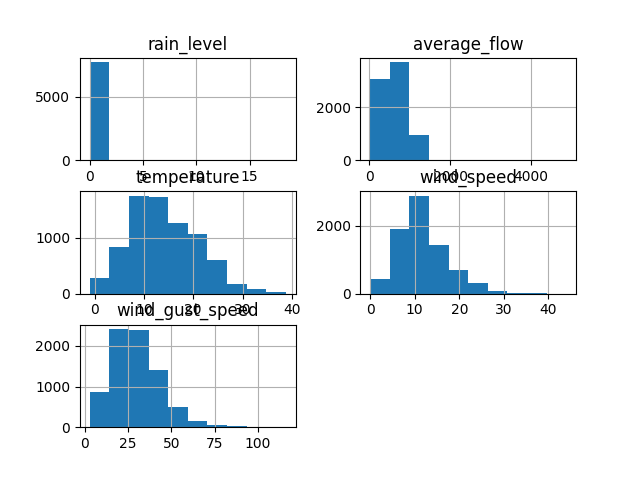

In [7]:
x_train.hist(['rain_level','average_flow','temperature','wind_speed','wind_gust_speed'])
plt.show()

## Prepration of exogene variables

In [9]:
x_train.temperature.fillna(method='ffill',inplace=True)
x_train.rain_level.fillna(method='ffill',inplace=True)
x_train.average_flow.fillna(method='ffill',inplace=True)
x_train.wind_speed.fillna(method='ffill',inplace=True)
x_train.wind_gust_speed.fillna(method='ffill',inplace=True)
x_train.traffic_state.fillna(method='ffill',inplace=True)
reps={'Available':4,'Charging':3,'Passive':2,'Offline':1,'Down':0}
x_test.temperature.fillna(method='ffill',inplace=True)
x_test.rain_level.fillna(method='ffill',inplace=True)
x_test.average_flow.fillna(method='ffill',inplace=True)
x_test.wind_speed.fillna(method='ffill',inplace=True)
x_test.wind_gust_speed.fillna(method='ffill',inplace=True)
x_test.traffic_state.fillna(method='ffill',inplace=True)

# clean={i:reps for i in y_train.columns[1:]}
# y_train.replace(clean,inplace=True)

x_train.replace({'traffic_state':{'Fluid':0,"Busy":1,"Heavy":2}},inplace=True)
x_test.replace({'traffic_state':{'Fluid':0,"Busy":1,"Heavy":2}},inplace=True)

# One column one NN approach

In [21]:
encoder = LabelEncoder()
encoder.fit(y_train.iloc[:,1].fillna(method='ffill'))
encoded_Y = encoder.transform(y_train.iloc[:,1].fillna(method='ffill'))
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

NnBlmodel = Sequential()
NnBlmodel.add(Dense(8, input_dim=x_train.iloc[:,1:].shape[1], activation='relu'))
NnBlmodel.add(Dense(3, activation='softmax'))
# Compile model
NnBlmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NnBlmodel.fit(x_train.iloc[:,1:],dummy_y,epochs=200)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

## Preparation of the the target values

In [ ]:
y_doom=pd.get_dummies(y_train.drop(['timestamp'],axis='columns'))
states=['Available','Charging','Passive','Offline','Down']
cols=list(y_train.drop(['timestamp'],axis='columns').columns)
doom_cols=[i+'_'+j for i in cols for j in states]
for i in doom_cols:
    if i not in  list(y_doom.columns):
        y_doom[i]=0
y_doom=y_doom[doom_cols]
y_doom['timestamp']=pd.to_datetime(y_train.timestamp)
y_doom.set_index('timestamp',inplace=True)

In [ ]:
idx=pd.date_range(list(y_doom.index)[0],list(y_doom.index)[-1],freq="H")[~pd.date_range(list(y_doom.index)[0],list(y_doom.index)[-1],freq="H").isin(y_doom.index)]
pd.DataFrame({i:np.nan for i in y_doom.columns},index=idx)
y_doom=y_doom.append(pd.DataFrame({i:np.nan for i in y_doom.columns},index=idx)).sort_index()
#  Forward fill for the missing values
y_doom.fillna(method='ffill',inplace=True)

In [ ]:
def prepare_ts_date(df,look_back=1):
    dataX, dataY = [], []
    for i in range(len(df)-look_back-1):
        a = df.iloc[i:(i+look_back)].to_numpy()
        dataX.append(a)
        dataY.append(df.iloc[i + look_back])
    return np.array(dataX), np.array(dataY)

In [ ]:
x,y=prepare_ts_date(y_train,1)


In [ ]:
# x_train.drop(['timestamp'],axis='columns',inplace=True)
# X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_doom)
model= tf.keras.models.Sequential([
    tf.keras.layers.LSTM(300, input_shape=(x.shape[1],x.shape[2]),return_sequences=True),
    tf.keras.layers.LSTM(300,return_sequences=True),
    tf.keras.layers.Dense(1365,activation='softmax')

])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["acc"])


In [ ]:
history=model.fit(x,y.reshape(y.shape[0],1,y.shape[1]),epochs=200)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,Y_train)
y_hat=clf.predict(X_val)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_val,y_hat)

In [ ]:
y_hat2=clf.predict(x_test.drop(['timestamp'],axis='columns'))